# Проект по опредлению успешности компьютерной игры

**Описание проекта**

*Заказчик*: Интернет-магазине «Стримчик», продающий по всему миру компьютерные игры. 

Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation).

*Необходимо выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.*

**Название столбцов в данных:**

* Name — название игры
* Platform — платформа
* Year_of_Release — год выпуска
* Genre — жанр игры
* NA_sales — продажи в Северной Америке (миллионы проданных копий)
* EU_sales — продажи в Европе (миллионы проданных копий)
* JP_sales — продажи в Японии (миллионы проданных копий)
* Other_sales — продажи в других странах (миллионы проданных копий)
* Critic_Score — оценка критиков (максимум 100)
* User_Score — оценка пользователей (максимум 10)
* Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг  компьютерных игр и присваивает им подходящую возрастную категорию.

**Интерпритация ESRB Rating на русский**

* *E*  --  для всех
* *K-A* -- для всех
* *EC* -- для детей младшего возраста 3+
* *E10+* -- для всех 10+
* *T*  --  подросткам 13+
* *M*  --  для взрослых 17+
* *AO* -- только для взрослых 18+

* *RP* -- рейтинг ожидается

### Первый взгляд на данные

In [4]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st
import plotly.graph_objs as go

pd.options.mode.chained_assignment = None 

In [5]:
# чтение данных
df=pd.read_csv('https://code.s3.yandex.net/datasets/games.csv')
df = df.rename(columns=str.lower)

In [6]:
df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  float64
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       10014 non-null  object 
 10  rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Присутствует множество пропусков в оценках игр

In [8]:
df.shape

(16715, 11)

In [9]:
# замена NaN в столбике "year_of_release" (год выпуска) на контрастное значение "0", изменение типа на Int
df['year_of_release'] = df['year_of_release'].fillna(0)
df['year_of_release'] = df['year_of_release'].astype(int)

In [10]:
# выявление шкалы оценивания критиков и пользователей
print('Шкала оценивания критиков')
print('Уникальные значения от', df.critic_score.min(),'до', df.critic_score.max())
print('Шкала оценивания пользователей')
print('Уникальные значения от', (df[df.user_score!='tbd']['user_score']).astype(float).min(),'до', (df[df.user_score!='tbd']['user_score']).dropna().astype(float).max())

Шкала оценивания критиков
Уникальные значения от 13.0 до 98.0
Шкала оценивания пользователей
Уникальные значения от 0.0 до 9.7


Для критиков шкала оценивания игр - целые числа от 0 до 100, для пользователей - дробные числа от 0 до 10

In [11]:
print('Уникальные жанры игр')
print(df['genre'].unique())

Уникальные жанры игр
['Sports' 'Platform' 'Racing' 'Role-Playing' 'Puzzle' 'Misc' 'Shooter'
 'Simulation' 'Action' 'Fighting' 'Adventure' 'Strategy' nan]


In [12]:
# замена рейтинга на русскую интерпритацию
df['rating_ru'] = df['rating'].replace({'E': 'Для всех', 'M': 'Для взрослых 17+', 'T': 'Подросткам 13+',
 'E10+': 'Для всех 10+', 'K-A': 'Для всех', 'AO': 'Только для взрослых 18+', 
 'EC': 'Для детей младшего возраста 3+', 'RP': 'Рейтинг ожидается'})

In [13]:
# замена пропусков в категориях
df['rating_ru'].fillna('Отсутствует', inplace=True)
df['rating'].fillna('Unknown', inplace=True)

In [14]:
# как видно из уникальных значений столбец 'critic_score' состоит из целых чисел в дробном формате, переводим их в тип Int64
df['critic_score'] = df['critic_score'].astype('Int64')
# как видно из уникальных значений столбец 'user_score' состоит из дробных чисел в строковом формате, переводим в тип float64 
# (перед этим заменяем значение 'tbd' на NaN, тк оно означениет "подлежит уточнению", тоесть неизвестно)
df.loc[(df['user_score']=='tbd'),'user_score']=np.nan
df['user_score'] = df['user_score'].astype('float64')
# заменяем тип значений в столбце 'rating_ru' и 'genre' на 'category' 
df['rating_ru'] = df['rating_ru'].astype('category')
df['genre'] = df['genre'].astype('category')

In [15]:
# создание столбца с суммарными продажами по всем регионам
df['total_sales'] = df[['na_sales','eu_sales','jp_sales', 'other_sales']].sum(axis = 1)

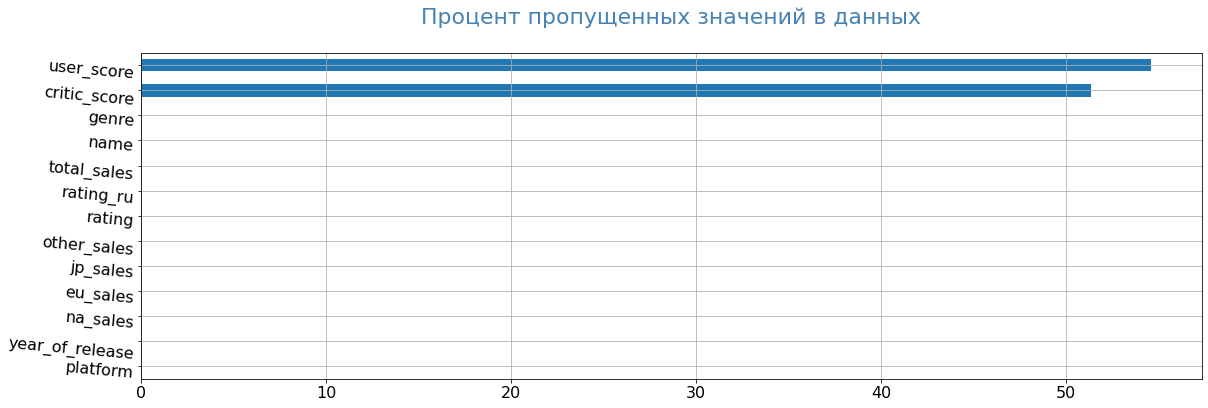

In [16]:
# создание гистограммы с процентом пропущенных значений в данных по столбцам
def pass_value_barh(df):
    (
        (df.isna().mean()*100)
        .to_frame()
        .rename(columns = {0:'space'})
        .sort_values(by = 'space', ascending = True)
        .plot(kind= 'barh', figsize=(19,6), rot = -5, legend = False, fontsize = 16,grid=True)
        .set_title('Процент пропущенных значений в данных' + "\n", fontsize = 22, color = 'SteelBlue')    
    );    
    
pass_value_barh(df)

In [17]:
df.isna().sum()

name                  2
platform              0
year_of_release       0
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         9125
rating                0
rating_ru             0
total_sales           0
dtype: int64

In [18]:
# удаление пропусков в названии игр
df.dropna(subset=['name'], inplace=True)

**Пропуски в данных**

1. Причины появления пропусков в данных:

Как можно заметить из гистограммы выше, пропуски присутствуют в 3 столбцах - Оценка пользователей, Оценка критиков, Возростной рейтинг игры

Отсутствие данных в оценках пользователей и критиков для игр до 2000х можно объяснить тем, что когда в эти игры играли данные еще не собирались или не сохранились. Для игр после 2000х причинами потери данных можно назвать - неаккуратность в их сборе, не верном форматировании или сохранении, либо их отсутствие (оценок нет, еще не собрались специалистами (в основном для игр 2016 года))

Отсутствие данных в рейтинге для игр 2016 года может быть объяснено тем, что оценка рейтинга еще в работе, для остальных игр это странно, так как рейтинг есть у всего развлекательного контента и его отсутствие объясняется лишь технической составляющей агригации данных.

2. Пропуски пока решено не заполнять, лучше изучить DF более детально, чтобы понять, что можно заменить


### Исследовательский анализ данных

#### Количество выпущенных игр в разные годы

In [19]:
# группировка данных о выпуске игр по годам
number_of_games = df.groupby('year_of_release')[['name','total_sales']]\
                    .agg({'name':'count','total_sales':'sum'})\
                    .reset_index()\
                    .rename(columns={'name':'number_of_games'})
number_of_games.sort_values(by='total_sales', ascending=False).head(10)

,year_of_release,number_of_games,total_sales
29,2008,1427,671.50
30,2009,1426,658.82
28,2007,1197,604.75
31,2010,1255,590.13
27,2006,1006,517.71
32,2011,1136,507.58
26,2005,939,457.82
25,2004,762,418.68
23,2002,829,394.97
34,2013,544,361.24


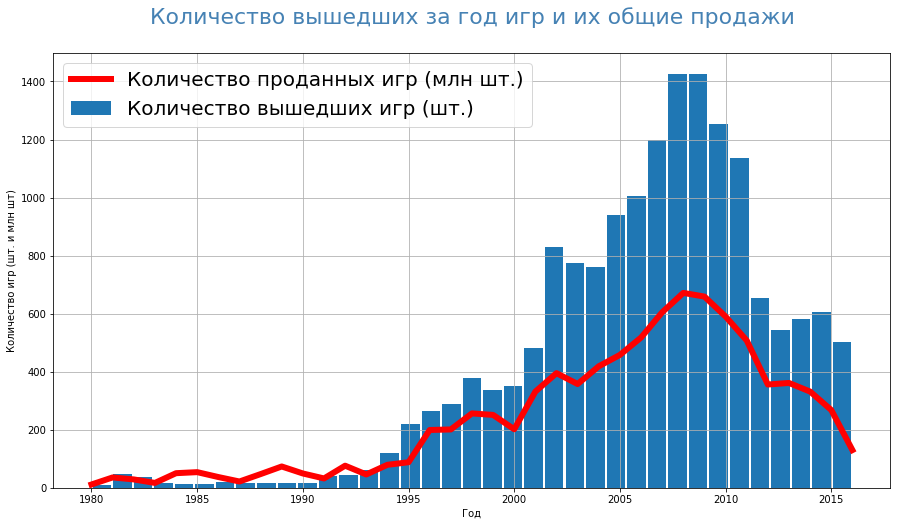

In [20]:
# построение гистограмы с количеством игр, выпущенных в разные годы и их продажами
r=df[df['year_of_release']>0]['year_of_release']

fig, ax = plt.subplots(figsize=(15,8))

plt.hist(x=r, bins=37, rwidth = 0.9);
r2=number_of_games.query('year_of_release>0')
x=r2['year_of_release']
y=r2['total_sales']
plt.plot(x,y,color = 'red', linewidth=6);
plt.grid()
ax.set_xlabel('Год');
ax.set_ylabel('Количество игр (шт. и млн шт)');
ax.set_title('Количество вышедших за год игр и их общие продажи'+ "\n", fontsize = 22, color = 'SteelBlue');
ax.legend( ['Количество проданных игр (млн шт.)', 'Количество вышедших игр (шт.)'], fontsize=(20));

Можно убрать данные об играх, вышедших ранее 1995 года, так как они не являются популярными среди современных пользователей, что протеворичит цели нашего анализа, а так же имеют невысокие продажи. Неизвесные данные можно так же отрезать.

In [21]:
df_dropped = df[df['year_of_release']>=1995]

#### Продажи по платформам. Платформы с наибольшими суммарными продажами, распределение по годам

In [22]:
# выявление самой популярной платформы (Топ продаж)

grouped_by_platform = df_dropped.groupby('platform')[['name','total_sales']]\
                    .agg({'name':'count','total_sales':'sum'})\
                    .reset_index()\
                    .rename(columns={'name':'number_of_games_released'})
grouped_by_platform.sort_values(by='total_sales', ascending=False)

,platform,number_of_games_released,total_sales
12,PS2,2127,1233.56
23,X360,1232,961.24
13,PS3,1306,931.34
21,Wii,1286,891.18
3,DS,2120,802.76
11,PS,1173,721.55
14,PS4,392,314.14
5,GBA,811,312.88
15,PSP,1193,289.53
1,3DS,512,257.81


In [23]:
# количество выпущенных игр и общее число продаж по платформам и годам
platform_sales = df_dropped.pivot_table(index=['year_of_release','platform'],
                       values=['name','total_sales'],
                       aggfunc={'name':'count','total_sales':'sum'}).rename(columns={'name':'number_of_games_released'})
platform_sales.head(16)

number_of_games_released  total_sales
year_of_release platform                                       
1995            3DO                              2         0.08
                GB                               4         3.60
                NG                               4         0.33
                PC                               2         4.22
                PS                              99        35.96
                SAT                             52        11.57
                SNES                            54        32.20
                TG16                             2         0.16
1996            GB                               6        36.03
                N64                             18        34.10
                NG                               2         0.10
                PC                               4        10.58
                PCFX                             1         0.03
                PS                             164        94.70
                SAT                             38         7.69
                SNES                            30        15.92

In [24]:
# выявление максимального значения из группы года
platform_sales ['max_value'] = platform_sales.groupby(['year_of_release'])['total_sales'].transform(max).to_frame()
platform_sales.head(8)

number_of_games_released  total_sales  max_value
year_of_release platform                                                  
1995            3DO                              2         0.08      35.96
                GB                               4         3.60      35.96
                NG                               4         0.33      35.96
                PC                               2         4.22      35.96
                PS                              99        35.96      35.96
                SAT                             52        11.57      35.96
                SNES                            54        32.20      35.96
                TG16                             2         0.16      35.96

In [25]:
# агригация информации о максимальных значениях по годам
platform_sales[platform_sales['total_sales']==platform_sales['max_value']]

,,number_of_games_released,total_sales,max_value
year_of_release,platform,,,
1995,PS,99,35.96,35.96
1996,PS,164,94.70,94.70
1997,PS,188,136.17,136.17
1998,PS,248,169.49,169.49
1999,PS,200,144.53,144.53
2000,PS,160,96.37,96.37
2001,PS2,185,166.43,166.43
2002,PS2,280,205.38,205.38
2003,PS2,256,184.31,184.31


In [26]:
# сбор данных в какие годы были продажи по платформам
grouped_by_platform_year = df_dropped.pivot_table(index=['platform','year_of_release'],
                       values=['name'],
                       aggfunc='count')
grouped_by_platform_year.drop('name',axis=1,inplace=True)

grouped_by_platform_year.head()

Empty DataFrame
Columns: []
Index: [(3DO, 1995), (3DS, 2011), (3DS, 2012), (3DS, 2013), (3DS, 2014)]

In [27]:
# выявление сколько лет были продажи по платформам
grouped_by_platform_year=grouped_by_platform_year.reset_index()

grouped_by_platform_year['max'] = grouped_by_platform_year.groupby(['platform'])['year_of_release'].transform(max)
grouped_by_platform_year['min'] = grouped_by_platform_year.groupby(['platform'])['year_of_release'].transform(min)
grouped_by_platform_year['delta'] = grouped_by_platform_year.groupby(['platform'])['year_of_release'].transform(max)\
                                   -grouped_by_platform_year.groupby(['platform'])['year_of_release'].transform(min)\
                                   + 1
grouped_by_platform_year

,platform,year_of_release,max,min,delta
0,3DO,1995,1995,1995,1
1,3DS,2011,2016,2011,6
2,3DS,2012,2016,2011,6
3,3DS,2013,2016,2011,6
4,3DS,2014,2016,2011,6
...,...,...,...,...,...
182,XB,2008,2008,2000,9
183,XOne,2013,2016,2013,4
184,XOne,2014,2016,2013,4
185,XOne,2015,2016,2013,4


In [28]:
grouped_by_platform_year.set_index(['platform','year_of_release'])

max   min  delta
platform year_of_release                   
3DO      1995             1995  1995      1
3DS      2011             2016  2011      6
         2012             2016  2011      6
         2013             2016  2011      6
         2014             2016  2011      6
...                        ...   ...    ...
XB       2008             2008  2000      9
XOne     2013             2016  2013      4
         2014             2016  2013      4
         2015             2016  2013      4
         2016             2016  2013      4

[187 rows x 3 columns]

In [29]:
# удаление дубликатов в таблице и удаление лишних столбцов
grouped_by_platform_year_delta=grouped_by_platform_year.reset_index(drop=True)
grouped_by_platform_year_delta=grouped_by_platform_year_delta.drop(columns=['year_of_release','max','min'])
grouped_by_platform_year_delta=grouped_by_platform_year_delta.drop_duplicates()
grouped_by_platform_year_delta.sort_values(by='delta',ascending=False).reset_index(drop=True).head(10)

,platform,delta
0,PC,22
1,PSP,12
2,PS2,12
3,X360,12
4,Wii,11
5,PS3,11
6,DC,11
7,DS,10
8,XB,9
9,PS,9


In [30]:
# проверка на продажи в 2016 году
t=list(df_dropped.query('year_of_release==2016')['platform'].unique())
grouped_by_platform_year_delta['2016']=np.where(grouped_by_platform_year_delta['platform'].isin(t), '2016', "X")
grouped_by_platform_year_delta.sort_values(['2016','delta']).reset_index(drop=True).head(10)

,platform,delta,2016
0,PS4,4,2016
1,XOne,4,2016
2,WiiU,5,2016
3,3DS,6,2016
4,PSV,6,2016
5,PS3,11,2016
6,Wii,11,2016
7,X360,12,2016
8,PC,22,2016
9,3DO,1,X


In [31]:
# сбор информации о топе продаж игр по платформам
grouped_by_platform.sort_values('platform')
grouped_by_platform_year_delta.sort_values('platform')
merged=grouped_by_platform.merge(grouped_by_platform_year_delta, how='inner')
merged.sort_values(['total_sales'],ascending=False).reset_index(drop=True).head(10)

,platform,number_of_games_released,total_sales,delta,2016
0,PS2,2127,1233.56,12,X
1,X360,1232,961.24,12,2016
2,PS3,1306,931.34,11,2016
3,Wii,1286,891.18,11,2016
4,DS,2120,802.76,10,X
5,PS,1173,721.55,9,X
6,PS4,392,314.14,4,2016
7,GBA,811,312.88,8,X
8,PSP,1193,289.53,12,X
9,3DS,512,257.81,6,2016


In [32]:
# среднее количество лет на рынке игр, продаж которых не было в 2016 году
print('Среднее количество лет на рынке игр, продаж которых не было в 2016 году - ', 
      grouped_by_platform_year_delta[grouped_by_platform_year_delta['2016']=='X']['delta'].mean().round(2))

Среднее количество лет на рынке игр, продаж которых не было в 2016 году -  6.47


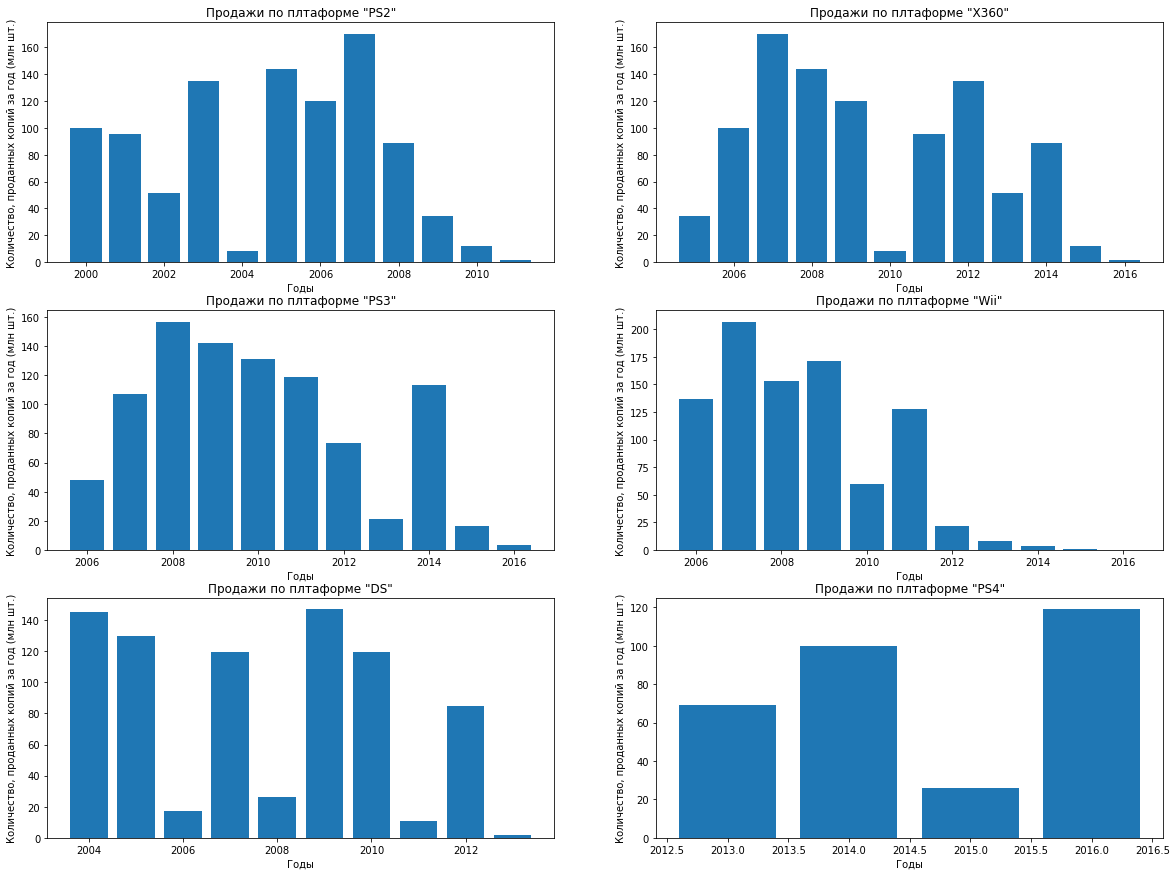

In [33]:
# построение гистограм по продажам за год среди 6 самых популярных игр
fig, ax = plt.subplots(3,2,figsize=(20,15))
        
x1=df_dropped.query('platform=="PS2"')['year_of_release'].unique()
y1=df_dropped.query('platform=="PS2"').groupby('year_of_release')['total_sales'].agg(sum)

x2=df_dropped.query('platform=="X360"')['year_of_release'].unique()
y2=df_dropped.query('platform=="X360"').groupby('year_of_release')['total_sales'].agg(sum)

x3=df_dropped.query('platform=="PS3"')['year_of_release'].unique()
y3=df_dropped.query('platform=="PS3"').groupby('year_of_release')['total_sales'].agg(sum)

x4=df_dropped.query('platform=="Wii"')['year_of_release'].unique()
y4=df_dropped.query('platform=="Wii"').groupby('year_of_release')['total_sales'].agg(sum)

x5=df_dropped.query('platform=="DS"')['year_of_release'].unique()
y5=df_dropped.query('platform=="DS"').groupby('year_of_release')['total_sales'].agg(sum)

x6=df_dropped.query('platform=="PS4"')['year_of_release'].unique()
y6=df_dropped.query('platform=="PS4"').groupby('year_of_release')['total_sales'].agg(sum)

ax[0,0].bar(x1,y2)
ax[0,0].set_title('Продажи по плтаформе "PS2"')
ax[0,0].set_xlabel('Годы')
ax[0,0].set_ylabel('Количество, проданных копий за год (млн шт.)');

ax[0,1].bar(x2,y2)
ax[0,1].set_title('Продажи по плтаформе "X360"')
ax[0,1].set_xlabel('Годы')
ax[0,1].set_ylabel('Количество, проданных копий за год (млн шт.)');

ax[1,0].bar(x3,y3)
ax[1,0].set_title('Продажи по плтаформе "PS3"')
ax[1,0].set_xlabel('Годы')
ax[1,0].set_ylabel('Количество, проданных копий за год (млн шт.)');

ax[1,1].bar(x4,y4)
ax[1,1].set_title('Продажи по плтаформе "Wii"')
ax[1,1].set_xlabel('Годы')
ax[1,1].set_ylabel('Количество, проданных копий за год (млн шт.)');

ax[2,0].bar(x5,y5)
ax[2,0].set_title('Продажи по плтаформе "DS"')
ax[2,0].set_xlabel('Годы')
ax[2,0].set_ylabel('Количество, проданных копий за год (млн шт.)');

ax[2,1].bar(x6,y6);
ax[2,1].set_title('Продажи по плтаформе "PS4"')
ax[2,1].set_xlabel('Годы')
ax[2,1].set_ylabel('Количество, проданных копий за год (млн шт.)');

Проанализировав данные было принято решение сократить количество игр по годам до 2010 года, в соответствии со средним значением существования на рынке игр популярных по сей день (6 лет)

In [34]:
df_dropped = df_dropped[df_dropped['year_of_release']>=2010]

#### Платформы, лидирующие по продажам

In [35]:
# функция для отображения двух DF рядом
from IPython.display import display_html
from itertools import chain,cycle
def display_side_by_side(*args,titles=cycle([''])):
    html_str=''
    for df,title in zip(args, chain(titles,cycle(['</br>'])) ):
        html_str+='<th style="text-align:center"><td style="vertical-align:top">'
        html_str+=f'<h2 style="text-align: center;">{title}</h2>'
        html_str+=df.to_html().replace('table','table style="display:inline"')
        html_str+='</td></th>'
    display_html(html_str,raw=True)

grouped_by_platform2 = df_dropped.groupby('platform')[['name','total_sales']]\
                    .agg({'name':'count','total_sales':'sum'})\
                    .reset_index()\
                    .rename(columns={'name':'number_of_games_released'})
grouped_by_platform2=grouped_by_platform2.sort_values(by='total_sales', ascending=False).reset_index(drop=True)
grouped_by_platform=grouped_by_platform.sort_values(['total_sales'],ascending=False).reset_index(drop=True)
display_side_by_side(grouped_by_platform2.head(10), grouped_by_platform.head(10),
                     titles=['Топ платформ по продажам за период 2010-2016', 'Топ платформ по продажам за период 1995-2016'])

,platform,number_of_games_released,total_sales
0,PS3,889,587.74
1,X360,680,550.41
2,PS4,392,314.14
3,3DS,512,257.81
4,Wii,450,222.97
5,XOne,247,159.32
6,DS,507,123.75
7,PC,479,121.96
8,WiiU,147,82.19
9,PSP,500,64.05


Как видно из двух таблиц лидерство по продажам занимает PS3, а бывший лидер по продажам за 22 года - PS2 опустился ниже 10 строки 

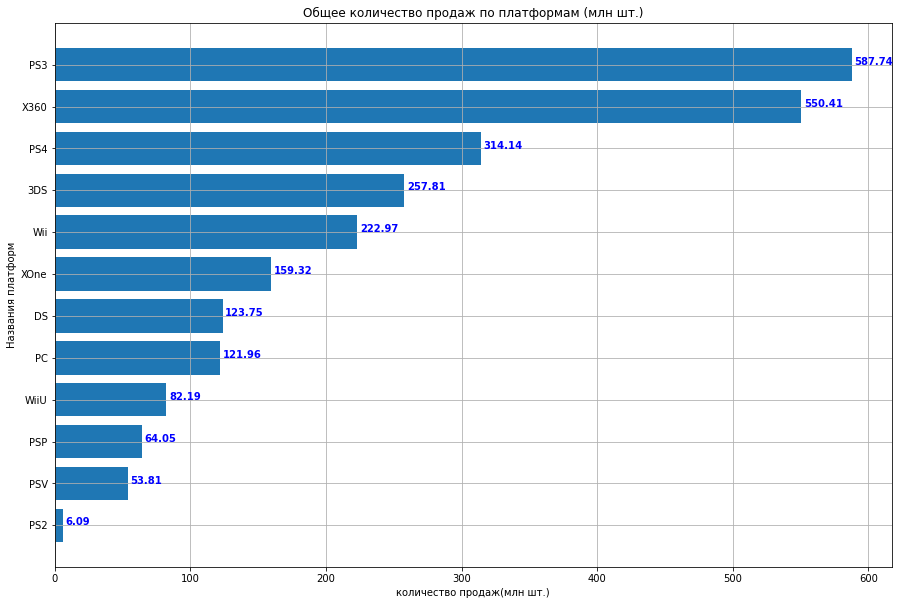

In [36]:
fig, ax = plt.subplots(figsize=(15,10))
x=grouped_by_platform2.sort_values('total_sales')['platform']
y=grouped_by_platform2['total_sales'].sort_values()
plt.barh(x,y)
ax.set_title('Общее количество продаж по платформам (млн шт.)')
ax.set_xlabel('количество продаж(млн шт.)')
ax.set_ylabel('Названия платформ')
ax.grid()
for i, v in enumerate(y):
    ax.text(v+2, i, str(round(v,2)), color='blue', fontweight='bold')
plt.show()

Как видно из гистограммы топ платформ по суммарным продажам - PS3, X360, PS4, 3DS, Wii  топ по минимальным продажам - PS2, PSV, PSP, WiiU, PC.

Однако как мы можем видеть из гистограм по распределению продаж наиболее популярных платформ за годы - число продаж значительно снизилось за последние время. Лидером среди популярных платформ можно назвать PS3, так как имеются стабильно высокие продажи за длительный период времени (не считая последние годы), так же можно выделить Х360, но имелся спад продаж в 2010 и 2015 год. Оценка общих продаж по 2016 году нецелесообразна.

#### Построение графика «ящик с усами» по глобальным продажам игр в разбивке по платформам

In [37]:
# функция для графика
def func_0(axis, xx, text):
  axis.boxplot(xx, vert=False)
  axis.set_title('Диаграмма размаха значений по продажам по плтаформе '+ text)
  axis.grid()
  axis.set_xlim([0, 2]);

In [38]:
# подготовка данных
x1=df_dropped.query('platform=="PS3"')['total_sales'].to_frame()
x2=df_dropped.query('platform=="X360"')['total_sales'].to_frame()
x3=df_dropped.query('platform=="PS4"')['total_sales'].to_frame()
x4=df_dropped.query('platform=="3DS"')['total_sales'].to_frame()
x5=df_dropped.query('platform=="Wii"')['total_sales'].to_frame()
x6=df_dropped.query('platform=="XOne"')['total_sales'].to_frame()

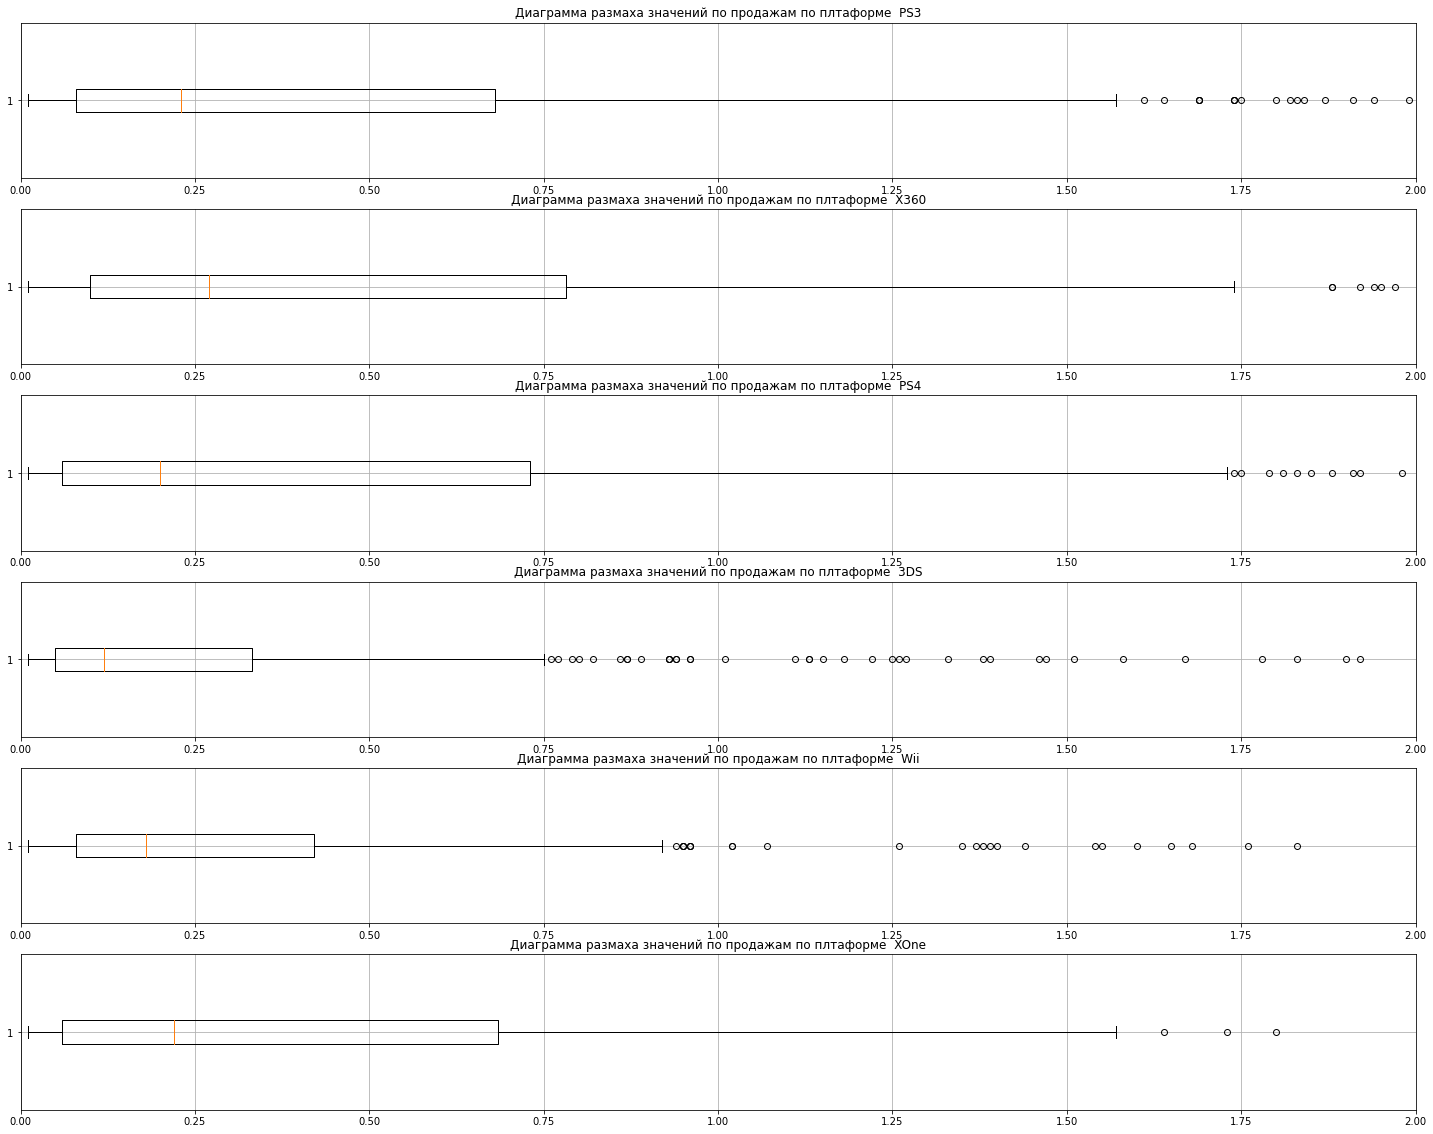

In [39]:
# построение графиков boxplot
fig,axes=plt.subplots(nrows=6,ncols=1,figsize=(25,20))

ax1,ax2,ax3,ax4,ax5,ax6 = axes.ravel()

func_0(ax1,x1,' PS3')
func_0(ax2,x2, ' X360')
func_0(ax3,x3, ' PS4')
func_0(ax4,x4, ' 3DS')
func_0(ax5,x5, ' Wii')
func_0(ax6,x6, ' XOne')

In [40]:
# функция для обобщения информации
def func_1(x,text):
  display(x['total_sales'].describe().to_frame().T)
  print('Общая сумма продаж за 6 лет:', x['total_sales'].sum().round(3))
  print('Медиана:', x['total_sales'].median().round(3));
  print(text)
  print()

In [41]:
# применение функции
print('Данные по общим продажам')
print()
func_1(df_dropped,'По всем платформам')
func_1(x1,'PS3')
func_1(x2,'X360')
func_1(x3,'PS4')
func_1(x4,'3DS')
func_1(x5,'Wii')
func_1(x6,'XOne')


Данные по общим продажам



,count,mean,std,min,25%,50%,75%,max
total_sales,5277.0,0.482138,1.235982,0.01,0.04,0.13,0.4,21.82


Общая сумма продаж за 6 лет: 2544.24
Медиана: 0.13
По всем платформам



,count,mean,std,min,25%,50%,75%,max
total_sales,889.0,0.661125,1.459651,0.01,0.08,0.23,0.68,21.05


Общая сумма продаж за 6 лет: 587.74
Медиана: 0.23
PS3



,count,mean,std,min,25%,50%,75%,max
total_sales,680.0,0.809426,1.818539,0.01,0.1,0.27,0.7825,21.82


Общая сумма продаж за 6 лет: 550.41
Медиана: 0.27
X360



,count,mean,std,min,25%,50%,75%,max
total_sales,392.0,0.801378,1.609456,0.01,0.06,0.2,0.73,14.63


Общая сумма продаж за 6 лет: 314.14
Медиана: 0.2
PS4



,count,mean,std,min,25%,50%,75%,max
total_sales,512.0,0.503535,1.441271,0.01,0.05,0.12,0.3325,14.6


Общая сумма продаж за 6 лет: 257.81
Медиана: 0.12
3DS



,count,mean,std,min,25%,50%,75%,max
total_sales,450.0,0.495489,1.118375,0.01,0.08,0.18,0.42,10.12


Общая сумма продаж за 6 лет: 222.97
Медиана: 0.18
Wii



,count,mean,std,min,25%,50%,75%,max
total_sales,247.0,0.64502,1.036139,0.01,0.06,0.22,0.685,7.39


Общая сумма продаж за 6 лет: 159.32
Медиана: 0.22
XOne



Среднее количество проданных копий - 0,482 млн, общее число проданных копий за 6 лет - 2544,24

Наибольшее значение 75% перцентиль плюс 1.5 х МКР у X360 - значит игры данной платформы имеют более высокий потенциал роста, далее идет PS4
 

#### Влияние отзывов пользователей и критиков на продажи внутри одной популярной платформы

##### PS3

In [42]:
ps3_df = df_dropped.query('platform=="PS3"')

In [43]:
print('Статистика "user_score"')
display(df_dropped['user_score'].describe().to_frame().T)
print()
print('Статистика "critic_score"')
display(df_dropped['critic_score'].describe().to_frame().T)

Статистика "user_score"


,count,mean,std,min,25%,50%,75%,max
user_score,2499.0,6.678311,1.521214,0.2,5.9,7.0,7.8,9.3



Статистика "critic_score"


,count,mean,std,min,25%,50%,75%,max
critic_score,2312.0,70.454152,13.561583,13.0,62.0,73.0,80.0,97.0


In [44]:
# перевод в целочисленные значения столбец с оценками пользователей
df_dropped['user_score']=df_dropped['user_score']*10
df_dropped['user_score']=df_dropped['user_score'].astype('Int64')

In [45]:
# функция для построения графика
def func_2 (data, al):
  if al == 0:
    sns.scatterplot(x='user_score', y='total_sales', data=data, hue='rating_ru')
    plt.title('Распределение общих продаж и оценок пользователей')
  else:
    sns.scatterplot(x='critic_score', y='total_sales', data=data, hue='rating_ru');
    plt.title('Распределение общих продаж и оценок критиков')
  plt.ylim(0, 5)
sns.set(rc={'figure.figsize':(15,5)})

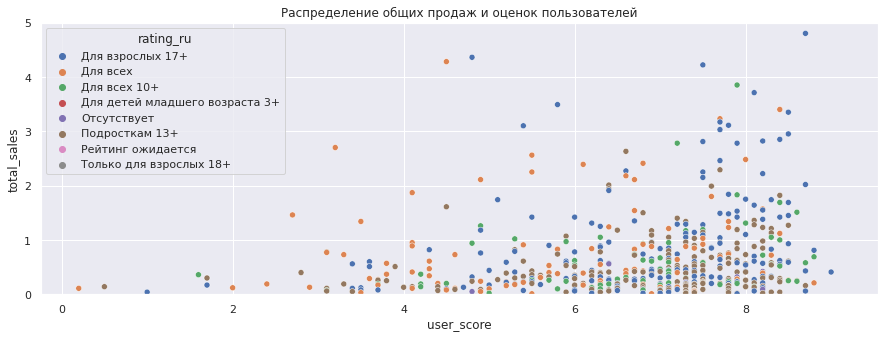

In [46]:
func_2(ps3_df, 0)

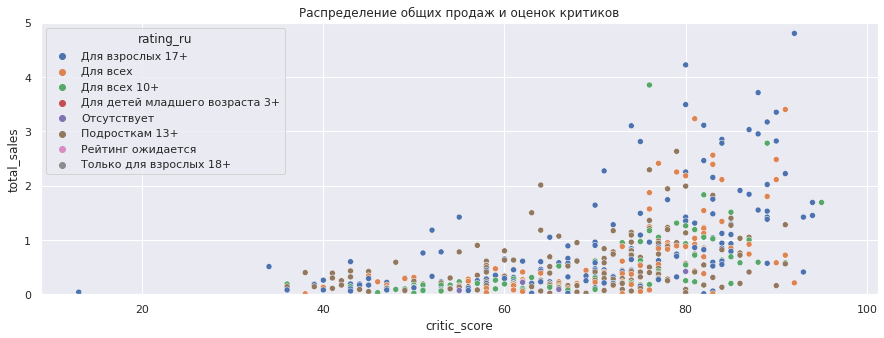

In [47]:
func_2(ps3_df, 1)

In [48]:
ps3_df[['total_sales','critic_score','user_score']].corr().round(4)*100

,total_sales,critic_score,user_score
total_sales,100.00,40.06,6.51
critic_score,40.06,100.00,59.53
user_score,6.51,59.53,100.00


Как видно из таблицы и графиков, более сильная зависимость между общими продажами и оценками критиков (40,06), чем оценками пользователей.

Кроме того, видна сильная зависимость  оценки пользователей от оценки критиков (59,53)

##### X360

In [49]:
x360_df = df_dropped.query('platform=="X360"')

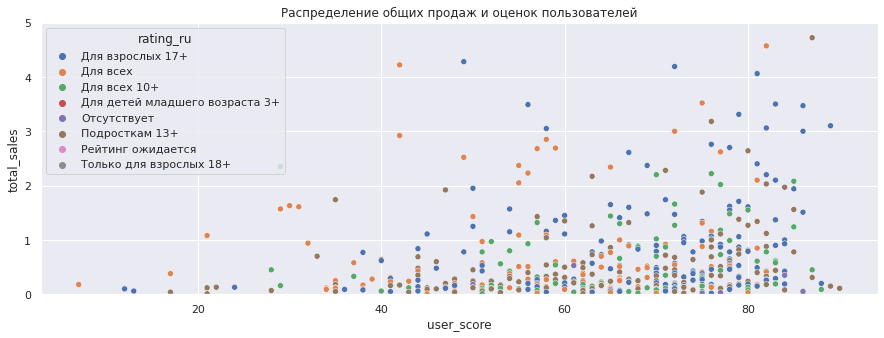

In [50]:
func_2(x360_df, 0)

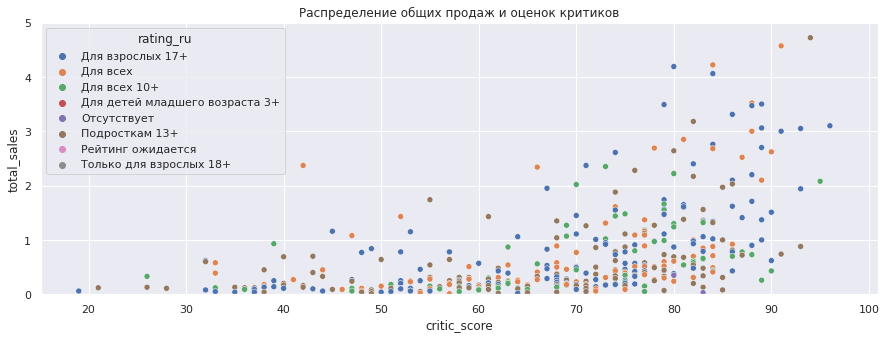

In [51]:
func_2(x360_df, 1)

In [52]:
x360_df[['total_sales','critic_score','user_score']].corr().round(4)*100

,total_sales,critic_score,user_score
total_sales,100.00,34.01,6.60
critic_score,34.01,100.00,59.76
user_score,6.60,59.76,100.00


Значения похожи на лидера - ps3, однако зависимость слабее - 34.01%

##### PS4

In [53]:
ps4_df = df_dropped.query('platform=="PS4"')

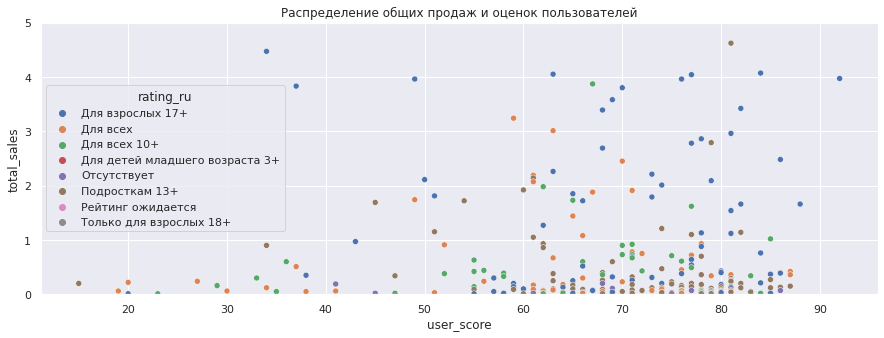

In [54]:
func_2(ps4_df, 0)

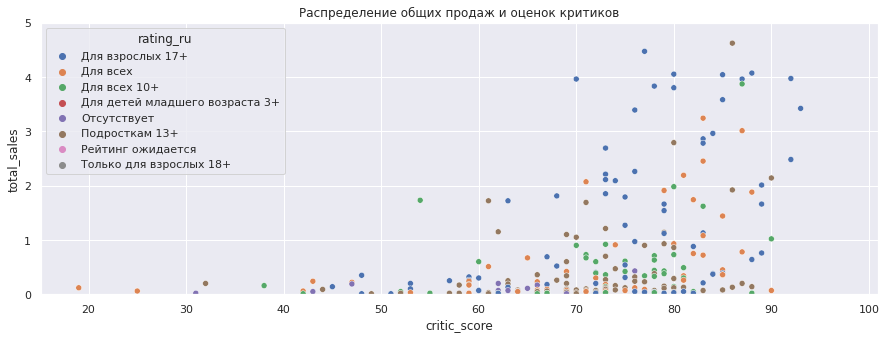

In [55]:
func_2(ps4_df, 1)

In [56]:
ps4_df[['total_sales','critic_score','user_score']].corr().round(4)*100

,total_sales,critic_score,user_score
total_sales,100.00,40.66,-3.20
critic_score,40.66,100.00,55.77
user_score,-3.20,55.77,100.00


Отрицательная корреляция между оценками пользователя и общими продажами, но незначителльно. Значения также схожи с лидерами (40.66%)

##### 3DS

In [57]:
_3ds_df = df_dropped.query('platform=="3DS"')

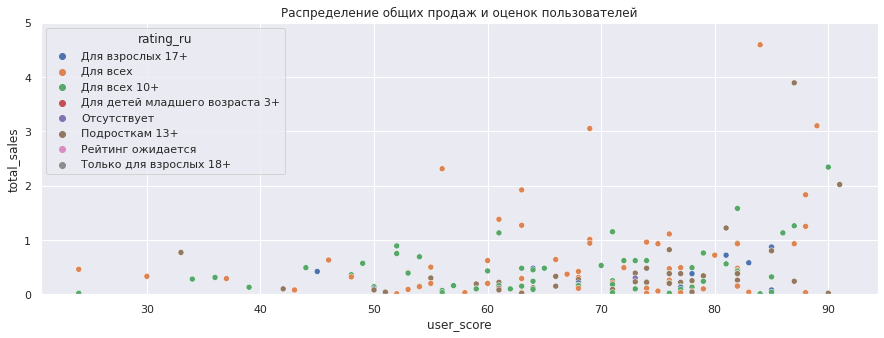

In [58]:
func_2(_3ds_df, 0)

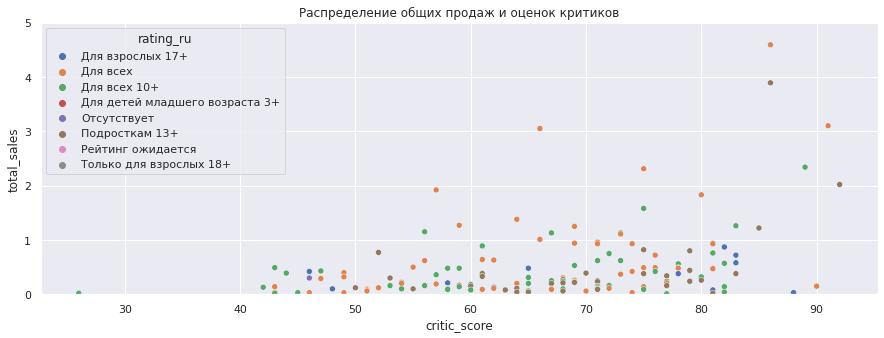

In [59]:
func_2(_3ds_df, 1)

In [60]:
_3ds_df[['total_sales','critic_score','user_score']].corr().round(4)*100

,total_sales,critic_score,user_score
total_sales,100.00,34.87,22.21
critic_score,34.87,100.00,74.52
user_score,22.21,74.52,100.00


БОльшая зависимость между общими продажами и оценками пользователей по сравнению с другими платформами (22,21), так же очень высокая положительная зависимость между оценками пользователей и критиков (74,52)

##### Wii

In [61]:
wii_df = df_dropped.query('platform=="Wii"')

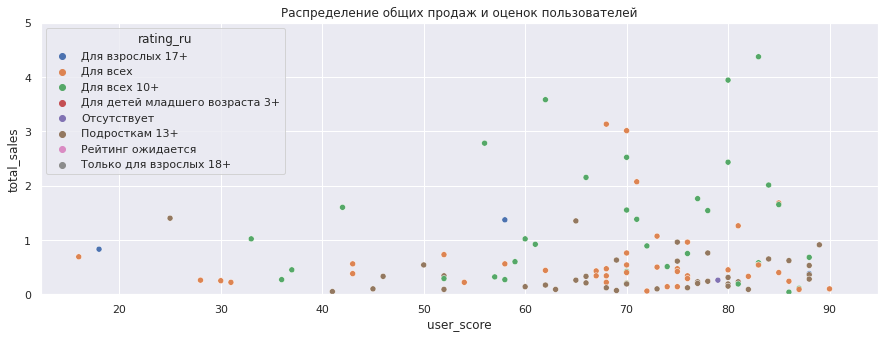

In [62]:
func_2(wii_df, 0)

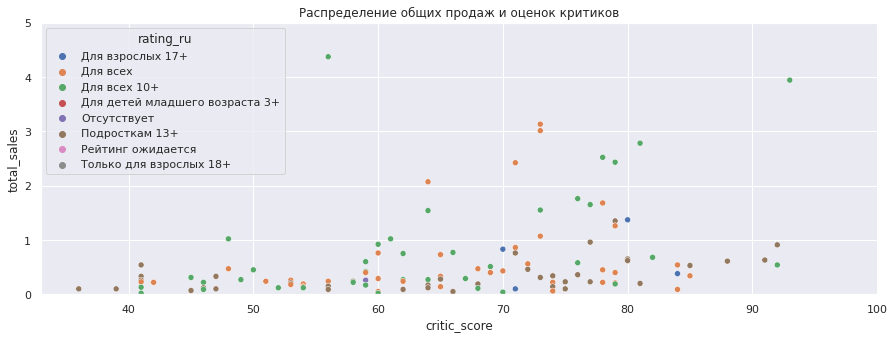

In [63]:
func_2(wii_df, 1)

In [64]:
wii_df[['total_sales','critic_score','user_score']].corr().round(4)*100

,total_sales,critic_score,user_score
total_sales,100.00,31.06,14.72
critic_score,31.06,100.00,47.17
user_score,14.72,47.17,100.00


Значения чуть ниже лидера - ps3

Итого
У всех платформ приблизительно близкие значения зависимости общих продаж от оценок критиков (положительные). Зависимость общих продаж от оценок пользователей также приблизительная равная, но значения минимальные, либо слегка отрицательные (как у PS4).
Также наблюдается высокая положительная зависимость между оценками критиков и пользователей.

#### Распределение игр по жанрам

In [65]:
# сводная таблица по жанрам - суммарные пользовательские оценки и критиков, а также суммарные продажи
genre_df = df_dropped.groupby(by='genre')[['critic_score','user_score','total_sales']].sum()
genre_df.sort_values('total_sales',ascending=False)

,critic_score,user_score,total_sales
genre,,,
Action,49049,52831,673.09
Shooter,21780,20950,479.74
Sports,18664,18590,328.39
Role-Playing,18558,19301,315.28
Misc,9663,9505,234.56
Racing,10045,9312,122.68
Platform,7220,7426,119.72
Fighting,8619,9132,81.59
Simulation,5109,5238,71.75


In [66]:
# сводная таблица по жанрам - средние пользовательские оценки и критиков, суммарные продажи
genre_df2 = pd.pivot_table(data=df_dropped,index='genre', values=['critic_score','user_score','total_sales'],
            aggfunc={'critic_score':['mean', 'median'],'user_score':['median','mean'], 'total_sales':[ 'mean','median', 'sum']})

genre_df2=genre_df2.sort_values(( 'total_sales',    'mean'), ascending=False).round(3)
genre_df2

critic_score        total_sales                user_score       
                     mean median        mean median     sum       mean median
genre                                                                        
Shooter            71.881   74.0       1.170  0.385  479.74     64.861   67.0
Platform           74.433   77.0       0.782  0.210  119.72     70.724   77.0
Sports             70.697   75.5       0.571  0.200  328.39     59.016   62.0
Role-Playing       73.063   74.0       0.555  0.150  315.28     72.834   75.0
Racing             70.739   73.0       0.518  0.170  122.68     63.781   66.5
Action             68.889   71.0       0.450  0.140  673.09     67.819   71.0
Fighting           70.073   74.0       0.410  0.180   81.59      69.71   73.0
Misc               69.021   73.0       0.407  0.130  234.56     66.469   69.0
Simulation         64.671   68.0       0.331  0.100   71.75     61.624   64.0
Strategy             73.5   76.0       0.211  0.080   35.84     66.278   71.0
Puzzle             71.741   71.0       0.181  0.070   20.60     71.143   74.0
Adventure          70.242   72.0       0.108  0.030   61.00     73.607   77.0

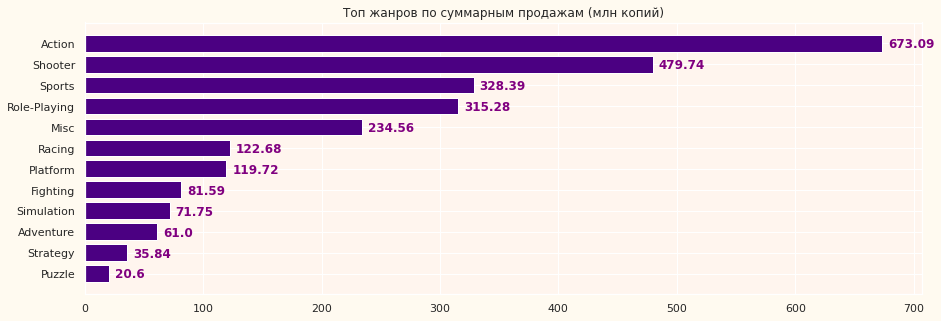

In [67]:
# топ жанров по суммарным продажам 
fig, ax = plt.subplots()
x=genre_df['total_sales'].sort_values().index
y=genre_df.total_sales.sort_values()
ax.barh(x, y, color = 'indigo')
for i, v in enumerate(y):
    ax.text(v+5, i-.2, str(round(v,2)), color='purple', fontweight='bold')
ax.set_facecolor('seashell')
fig.set_facecolor('floralwhite')
fig.set_figwidth(15) 
fig.set_figheight(5)

ax.set_title('Топ жанров по суммарным продажам (млн копий)');

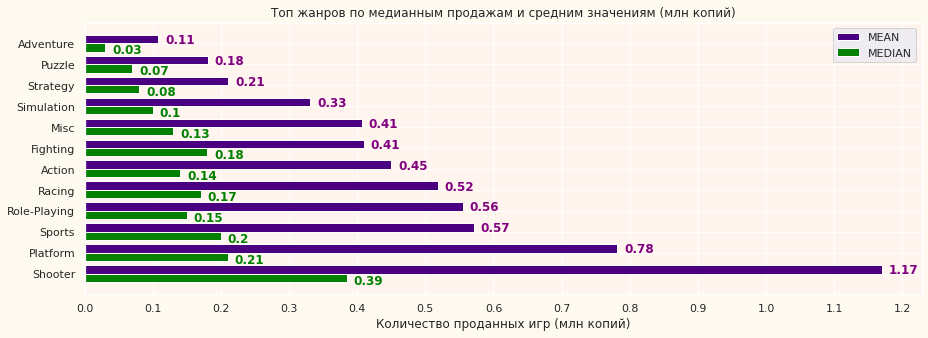

In [68]:
# топ жанров по медианным продажам и средним значениям
fig, ax = plt.subplots()
x=genre_df2.index
y=genre_df2[( 'total_sales', 'mean')]
z=genre_df2[( 'total_sales', 'median')]
X_axis = np.arange(len(x))
for i, v in enumerate(y):
  ax.text(v+.01, i, str(round(v,2)), color='purple', fontweight='bold')
for i, v in enumerate(z):
  ax.text(v+.01, i-.5, str(round(v,2)), color='green', fontweight='bold')

ax.barh(X_axis+.2, y,0.4, color = 'indigo', label = 'MEAN')
ax.barh(X_axis-.2, z, 0.4,color = 'green', label = 'MEDIAN')
ax.set_facecolor('seashell')
fig.set_facecolor('floralwhite')
plt.xticks(np.arange(0, 1.3, 0.1)) 
plt.yticks(X_axis, x)
plt.title('Топ жанров по медианным продажам и средним значениям (млн копий)')
plt.xlabel('Количество проданных игр (млн копий)')
plt.legend()
plt.show();


Из графиков можно видеть как поменялись лидеры при анализе суммарных продаж и медианных, либо средних значений.

* Суммарные значения -- Action, Shooter, Sports, Role-Playing, Misc

* Медианные значения -- Shooter, Platform, Sports, Fighting, Racing 

* Средние значения -- Shooter, Platform, Sports, Role-Playing, Racing

Жанр Action в последних потерял свое лидерство. Жанры Shooter и Sports - в трех способах занимают наивысшие позиции 

* **Action** - жанр компьютерных игр, в котором делается упор на эксплуатацию физических возможностей игрока, в том числе координации глаз и рук и скорости реакции.
* **Shooter** - жанр компьютерных игр, в которых игровой процесс основывается на сражениях с использованием огнестрельного или любого другого оружия с видом от первого лица таким образом, чтобы игрок воспринимал происходящее глазами протагониста.
* **Sports** -  это видеоигра, которая имитирует занятия спортом.
* **Role-Playing** - жанр компьютерных игр, основанный на элементах игрового процесса традиционных настольных ролевых игр. В ролевой игре игрок управляет одним или несколькими персонажами, каждый из которых описан набором численных характеристик, списком способностей и умений; примерами таких характеристик могут быть очки здоровья (англ. hit points, HP), показатели силы, ловкости, интеллекта, защиты, уклонения, уровень развития того или иного навыка и т. п.
* **Misc** - жанр компьютерных игр, характеризующийся коротким по времени, но интенсивным игровым процессом. В узком смысле аркадными называются игры для аркадных игровых автоматов. 
* **Puzzle** - название жанра компьютерных игр, целью которых является решение логических задач, требующих от игрока задействования логики, стратегии и интуиции.
* **Strategy** - жанр компьютерных игр, в которых игроку для победы необходимо применять стратегическое мышление.
* **Adventure** - жанр, в котором игрок управляет персонажем, продвигается по сюжету, решает головоломки и избегает опасностей.
* **Simulation** - жанр компьютерных и видео игр, где основой геймплея является наиболее подробная имитация какого либо действия.
* **Fighting** - жанр компьютерных игр, имитирующих рукопашный бой малого числа персонажей в пределах ограниченного пространства, называемого ареной.
* **Platform** - жанр компьютерных игр, в которых основу игрового процесса составляют прыжки по платформам, лазанье по лестницам, сбор предметов, необходимых для победы над врагами или завершения уровня.
* **Racing** - жанр компьютерных игр с видом от первого или от третьего лица, в которых игрок принимает участие в гоночном соревновании среди наземных, водных, воздушных или космических транспортных средств. 


In [69]:
# сводная таблица по жанрам и платформам
pvgp = df_dropped.groupby(['genre','platform'])[['name','total_sales']].agg({'name':'count','total_sales':['mean','median', 'max', 'sum']}).reset_index()
pvgp.columns=['genre','platform','number_of_games', 'total_sales_mean', 'total_sales_median','total_sales_max','total_sales_sum']
print('Максимальные медианные значения по жанру и платформе')
display(pvgp.groupby('genre', as_index=False).apply(lambda x: x.nlargest(1, 'total_sales_median')).sort_values(by='total_sales_median', ascending=False))

Максимальные медианные значения по жанру и платформе


,,genre,platform,number_of_games,total_sales_mean,total_sales_median,total_sales_max,total_sales_sum
8,107,Shooter,XOne,38,1.587632,1.095,7.39,60.33
4,57,Platform,WiiU,17,1.266471,0.580,5.23,21.53
10,125,Sports,PS4,46,1.208913,0.525,8.58,55.61
6,81,Racing,WiiU,3,2.623333,0.510,7.09,7.87
7,93,Role-Playing,WiiU,7,0.412857,0.410,0.84,2.89
2,28,Fighting,PS3,57,0.469298,0.320,2.85,26.75
0,10,Action,X360,188,0.762021,0.270,16.27,143.26
11,142,Strategy,X360,8,0.251250,0.255,0.62,2.01
3,45,Misc,WiiU,22,0.566364,0.215,4.42,12.46
9,113,Simulation,PS4,6,0.205000,0.210,0.42,1.23


По медианному значению количества проданных копий можно выделить жанр Shooter, продажи игр для платформы XOne - значение 1.095 млн копий, отличается от остальных почти в 2 раза (на 2 месте жанр Platform - платформа WiiU - 0.58 млн копий). Чем выше значение и ближе к максимальному, тем выше значение продаж в данной категории. 

**Общий вывод**

* Платформы с наибольшим количеством проданных копий с 2010 по 2016 год - PS3, X360, PS4

* Наиболее популярные жанры - Shooter, Sports, Platform
* Средние оценки пользователей и критиков не влияют на суммарные продажи

### Составление портрета пользователя каждого региона

Определение для пользователя каждого региона (NA, EU, JP):
* Самые популярные платформы (топ-5)
* Самые популярные жанры (топ-5)
* Влияет ли рейтинг ESRB на продажи в отдельном регионе?

In [70]:
platform_pivot = df_dropped.groupby(by = 'platform')[['na_sales', 'eu_sales', 'jp_sales','other_sales', 'total_sales']].sum()
platform_pivot.sort_values('total_sales', ascending=False)

,na_sales,eu_sales,jp_sales,other_sales,total_sales
platform,,,,,
PS3,229.25,213.60,59.26,85.63,587.74
X360,334.18,163.41,5.46,47.36,550.41
PS4,108.74,141.09,15.96,48.35,314.14
3DS,82.65,61.27,100.62,13.27,257.81
Wii,121.20,65.91,17.75,18.11,222.97
XOne,93.12,51.59,0.34,14.27,159.32
DS,59.66,28.06,27.90,8.13,123.75
PC,39.07,68.82,0.00,14.07,121.96
WiiU,38.10,25.13,13.01,5.95,82.19


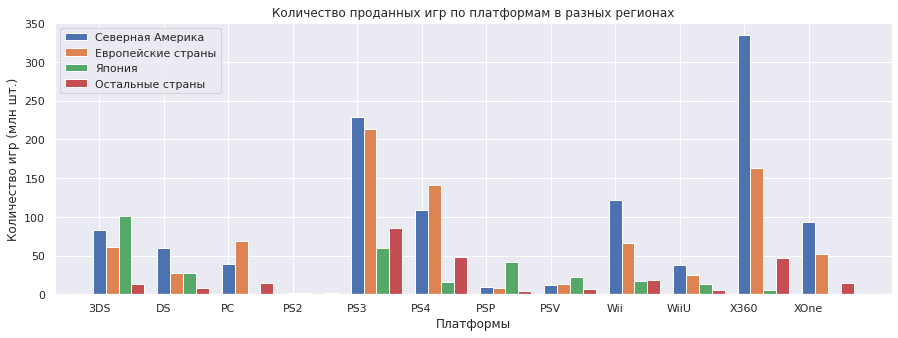

In [71]:
x = np.arange(len(platform_pivot.index))

y1=platform_pivot.na_sales
y2=platform_pivot.eu_sales
y3=platform_pivot.jp_sales
y4=platform_pivot.other_sales

width = 0.2

plt.bar(x, y1, width, label='Северная Америка')
plt.bar(x + width*1, y2, width, label='Европейские страны')
plt.bar(x + width*2, y3, width, label='Япония')
plt.bar(x + width*3, y4, width, label='Остальные страны')


plt.xlabel("Платформы")
plt.ylabel('Количество игр (млн шт.)')
plt.title("Количество проданных игр по платформам в разных регионах")
plt.xticks(x,platform_pivot.index)
plt.legend()

plt.show()

Как видно из гистограммы самые большие продажи у Северной Америки, самая популярныя платформа суммарно по всем регионам PS3, однако можно заметить, что в Северной Америке особой популярнстью пользуются игры для X360.

#### Северная Америка. Топ-5 платформ, жанров и возрастных рейтингов игр

In [72]:
# сводная таблица платформ
na_platform = pd.pivot_table(df_dropped, index='platform', values='na_sales',
                                        aggfunc='sum').sort_values('na_sales', ascending=False)
na_platform=na_platform.head(5)
# сводная таблица жанров
na_genre = pd.pivot_table(df_dropped, index='genre', values='na_sales',
                                        aggfunc='sum').sort_values('na_sales', ascending=False)
na_genre=na_genre.head(5)
# сводная таблица возрастных рейтингов игр
na_rating = pd.pivot_table(df_dropped, index='rating_ru', values='na_sales',
                                        aggfunc='sum').sort_values('na_sales', ascending=False)
na_rating=na_rating.head(5)


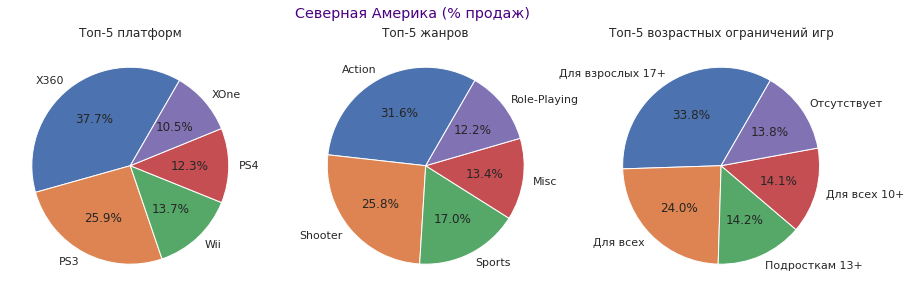

In [73]:
# построение диаграммы по региону Северная Америка
fig1, ax = plt.subplots(1,3,figsize=(15,15))
plt.suptitle('Северная Америка (% продаж)', y= 0.65, color='indigo')

labels=na_platform.index
ax[0].pie(na_platform.na_sales, labels=labels, startangle=60, autopct='%1.1f%%')
ax[0].set_title('Топ-5 платформ')

labels=na_genre.index
ax[1].pie(na_genre.na_sales, labels=labels, startangle=60, autopct='%1.1f%%')
ax[1].set_title('Топ-5 жанров')

labels=na_rating.index
ax[2].pie(na_rating.na_sales, labels=labels, startangle=60, autopct='%1.1f%%')
ax[2].set_title('Топ-5 возрастных ограничений игр')

plt.show()

**Платформа**
В Северной Америке наиболее популярной платформой является Х360 - производимая америанской компанией (цены на нее там скорее всего ниже чем на зарубежные бренды), далее по популярности идет PS3, Wii, PS4 - платформы японского производства. XOne занимает 5 место, ввиду своему моральному устареванию.

**Жанр** Наиболее популярным жанром игр в Северной Америке является Экшен, далее по популярности Шутер, Спортивные игры, Аркады и Ролевые. 

Экшен - жанр компьютерных игр, в котором делается упор на эксплуатацию физических возможностей игрока, в том числе координации глаз и рук и скорости реакции. Шутер, Спортивные игры - также требуют развитые физичесикие навыки играков.

Аркады - игры с коротким по времени, но интенсивным игровым процессом. Ролевые - игры в которых необходимо управлять персонажем.

Таким образом, в Северной Америке в основном предпочитают игры позволяющие проверить свои физические способности, в том числе координации глаз и рук и скорости реакции

**Возрастные ограничения** В Северной Америке в основном покупают игры с содержанием для лиц старше 17 лет, далее идут игры для всех и с небольшими возрастными ограничениями

#### Европейские страны. Топ-5 платформ, жанров и возрастных рейтингов игр

In [74]:
# сводная таблица платформ
eu_platform = pd.pivot_table(df_dropped, index='platform', values='eu_sales',
                                        aggfunc='sum').sort_values('eu_sales', ascending=False)
eu_platform=eu_platform.head(5)
# сводная таблица жанров
eu_genre = pd.pivot_table(df_dropped, index='genre', values='eu_sales',
                                        aggfunc='sum').sort_values('eu_sales', ascending=False)
eu_genre=eu_genre.head(5)
# сводная таблица возрастных рейтингов игр
eu_rating = pd.pivot_table(df_dropped, index='rating_ru', values='eu_sales',
                                        aggfunc='sum').sort_values('eu_sales', ascending=False)
eu_rating=eu_rating.head(5)

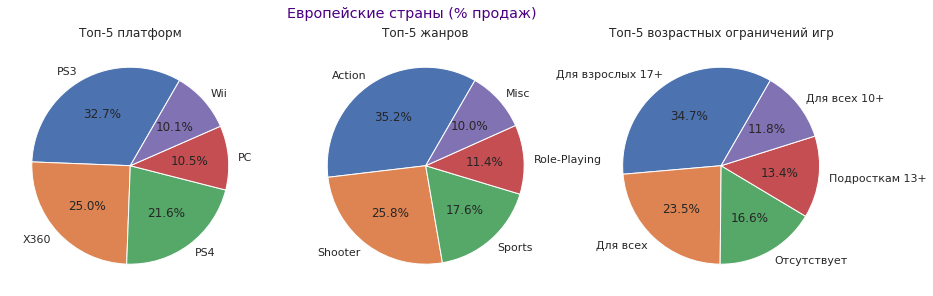

In [75]:
# построение диаграммы по Европейским странам
fig1, ax = plt.subplots(1,3,figsize=(15,15))
plt.suptitle('Европейские страны (% продаж)', y= 0.65, color='indigo')

labels=eu_platform.index
ax[0].pie(eu_platform.eu_sales, labels=labels, startangle=60, autopct='%1.1f%%')
ax[0].set_title('Топ-5 платформ')

labels=eu_genre.index
ax[1].pie(eu_genre.eu_sales, labels=labels, startangle=60, autopct='%1.1f%%')
ax[1].set_title('Топ-5 жанров')

labels=eu_rating.index
ax[2].pie(eu_rating.eu_sales, labels=labels, startangle=60, autopct='%1.1f%%')
ax[2].set_title('Топ-5 возрастных ограничений игр')

plt.show()

**Платформа** В Европе наибольшее число продаж имеют игры на платформе PS3, далее по популярности идут X360, PS4,PC,Wii.

Интересно, что в топе появились игры на платформе ПК и Нинтендо. 

**Жанр** В Европе топ жанров почти такой же как в Северной Америке, хотя последние позиции в топе поменялись местами.

Таким образом, в Европе также предпочитают игры позволяющие проверить свои физические способности, в том числе координации глаз и рук и скорости реакции

**Возрастные ограничения** В странах Европы такие же тренды как и в Северной Америке - в основном покупают игры с содержанием для лиц старше 17 лет, далее идут игры для всех и с небольшими возрастными ограничениями, либо вовсе отсутствуют

#### Япония. Топ-5 платформ, жанров и возрастных рейтингов игр

In [76]:
# сводная таблица платформ
jp_platform = pd.pivot_table(df_dropped, index='platform', values='jp_sales',
                                        aggfunc='sum').sort_values('jp_sales', ascending=False)
jp_platform=jp_platform.head(5)
# сводная таблица жанров
jp_genre = pd.pivot_table(df_dropped, index='genre', values='jp_sales',
                                        aggfunc='sum').sort_values('jp_sales', ascending=False)
jp_genre=jp_genre.head(5)
# сводная таблица возрастных ограничений игр
jp_rating = pd.pivot_table(df_dropped, index='rating_ru', values='jp_sales',
                                        aggfunc='sum').sort_values('jp_sales', ascending=False)
jp_rating=jp_rating.head(5)

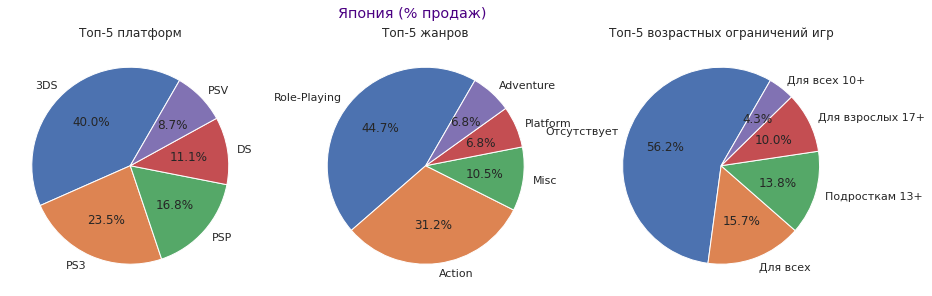

In [77]:
# построение диаграммы по Японии
fig1, ax = plt.subplots(1,3,figsize=(15,15))
plt.suptitle('Япония (% продаж)', y= 0.65, color='indigo')

labels=jp_platform.index
ax[0].pie(jp_platform.jp_sales, labels=labels, startangle=60, autopct='%1.1f%%')
ax[0].set_title('Топ-5 платформ')

labels=jp_genre.index
ax[1].pie(jp_genre.jp_sales, labels=labels, startangle=60, autopct='%1.1f%%')
ax[1].set_title('Топ-5 жанров')

labels=jp_rating.index
ax[2].pie(jp_rating.jp_sales, labels=labels, startangle=60, autopct='%1.1f%%')
ax[2].set_title('Топ-5 возрастных ограничений игр')

plt.show()

**Платформа** В Японии особой популярностью пользуются игры на платформе 3DS, далее идут PS3, PSP, DS, PSV. 

Можно оратить внимание, что в топе находятся поатформы японского производства, а также, что в основном это портативные консоли.

**Жанр** Наиболее популярным жанром игр в Японии является - ролевые игры, даже идет Экшен, Аркады, Платформы и Приключения.

В Японии игроки предпочитают брать под контроль определённого героя или героиню, с набором стандартных навыков, характеристик и умений. Жанр Экшен также предполагает, что персонаж должен найти выход из уровня, собрать предметы, избежать препятствий и сразиться с врагами разными способами, что требует определенных умени и навыков.

**Возрастные ограничения** В Японии в большей части игр отсутствует рейтинг (более 50% значений) - в основном популярны игры без возрастных ограничений, либо с минимальными, далее идут игры 17+. 

**Общие выводы по пункту:**

* Платформы - в Северной Америке наиболее популярная -  X360, в Европе PS3, в Японии - разные виды портативных консолей, а также PS3 
* Жанры - во всех регионах исследования в основном популярны жанры, позволяющие проверить свои физические способности, в том числе координации глаз и рук и скорости реакции
* Рейтинг игр - в Северной Америке и странах Европы большее количество игр имеет ограничение 17+, далее идут игры без возрастных ограничений или с минимальными, в Японии большая часть игр не имеет рейтинга, а следум идут игры с минимальными возрастными ограничениями

**Entertainment Software Rating Board (ESRB)** — негосударственная организация, основное направление деятельности — принятие и определение рейтингов для компьютерных видеоигр и другого развлекательного программного обеспечения в США и Канаде.

Поэтому в странах Европы и особенно в Японии в большей части игр отсутствует рейтинг ESRB

### Проверка гипотез

##### Гипотеза №1
H0  — средние пользовательские рейтинги платформ Xbox One и PC одинаковые.

H1 — средние пользовательские рейтинги платформ Xbox One и PC различаются.

In [78]:
alpha = 0.05

xone = df_dropped.query('platform == "XOne"')['user_score'].dropna().astype(float)
pc =df_dropped.query('platform == "PC"')['user_score'].dropna().astype(float)

# проверка гипотезы о равенстве среднего 2х генеральных совокупностей по выборкам
results = st.ttest_ind(xone, pc, equal_var=False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.9801634129117981
Не получилось отвергнуть нулевую гипотезу


Очень высокая вероятность, что результат гипотезы окажется таким случайно, тк как выше уровня значимости

In [79]:
# выявление средних значений пользовательских оценок по выбранным платформам
xone_pc = df_dropped.query('platform == "XOne" or platform == "PC"')
xone_pc['user_score']=xone_pc['user_score'].astype(float)
xone_pc.pivot_table(index='platform', values='user_score', aggfunc='mean')

,user_score
platform,
PC,65.181818
XOne,65.214286


Статистический тест показал, что гипотезу о равенстве среднего пользовательского рейтинга для XOne и PC не получилось отвергнуть.

##### Гипотеза №2

Н0 - Средние пользовательские рейтинги жанров Action и Sports одинаковые

Н1 - Средние пользовательские рейтинги жанров Action и Sports разные

In [80]:
alpha = .05

action = df_dropped.query('genre == "Action"')['user_score'].dropna().astype(float)
sports = df_dropped.query('genre == "Sports"')['user_score'].dropna().astype(float)

# проверка гипотезы о равенстве среднего 2х генеральных совокупностей по выборкам
results = st.ttest_ind(action, sports, equal_var=False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 1.451615246784473e-15
Отвергаем нулевую гипотезу


In [81]:
action_sports = df_dropped.query('genre == "Action" or genre == "Sports"')
action_sports['user_score']=action_sports['user_score'].astype(float)
action_sports.pivot_table(index='genre', values='user_score', aggfunc='mean')

,user_score
genre,
Action,67.818999
Sports,59.015873


Нулевая гипотеза не подтвердилась. Средние пользовательские рейтинги для жанров Action и Sports различаются. При выборе между продвижением игр двух жанров, при прочих равных условиях лучше отдать предпочтение жанру Action.

* **Как вы сформулировали нулевую и альтернативную гипотезы**

H₀ всегда формулируется так, чтобы использовать знак равенства. Другими словами, чтобы все данные лежали в районе изначально предполагаемого значения.

* **Какой критерий применили для проверки гипотез и почему**

Статистический Критерий Стьюдента

В Python есть специальный метод для проверки гипотезы о равенстве среднего двух генеральных совокупностей по взятым из них выборкам: scipy.stats.ttest_ind (array1, array2, equal_var) .

### Общий вывод

Проанализировав данные игр, вышедших за последние 6 лет (период был выбран как среднее зачение лет существования платлатформ на рынке) были сделаны выводы:

1. Лидерство по продажам во всем мире занимают игры на платформе PS3, следом идут X360 и PS4
2. Наибольшее значение верхней границы boxplot у платформы X360 - значит игры данной платформы имеют более высокий потенциал роста, далее идет PS4
3. У всех платформ приблизительно близкие значения зависимости общих продаж от оценок критиков (положительные). Зависимость общих продаж от оценок пользователей также приблизительная равная, но значения минимальные либо слегка отрицательные (как у PS4). Также наблюдается высокая положительная зависимость между оценками критиков и пользователей
4. Наиболее популярные жанры в мировых продажах - Shooter, Sports
5. В Северной Америке наиболее популярная платформа - X360 (является страной производителем), в Европе PS3, в Японии - разные виды портативных консолей, а также PS3 (является страной производителем)
6. Во всех регионах исследования в основном популярны жанры, позволяющие проверить свои физические способности, в том числе координации глаз и рук и скорости реакции
7. В Северной Америке и странах Европы большее количество игр имеет ограничение 17+, далее идут игры без возрастных ограничений или с минимальными, в Японии большая часть игр не имеет рейтинга, а следум идут игры с минимальными возрастными ограничениями
8. Средний пользовательский рейтинг для XOne и PC равны
9. Средние пользовательские рейтинги для жанров Action и Sports различны. При выборе между продвижением игр двух жанров, при прочих равных условиях лучше отдать предпочтение жанру Action.


Таким образом,

* игра должна быть разработана для платформ PS3 или XOne, если речь идет о западном рынке, и — для консольных платформ, если игру планируется продавать в Японии.
* жанр: Action или Shooter для Запада, Role-Playing — для Японии. Для всех популярны жанры, позволяющие проверить свои физические способности, в том числе координации глаз и рук и скорости реакции
* рейтинг ESRB: 17+ (для Америки и Европы), отсутствовать (для Японии)
* ориентироваться на оценки пользователей и критиков нет смысла, на продажи это не оказывает существенного влияния. Однако отзывы критиков иногда имеют высокую зависимость с отзывами пользователей